In [2]:
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torchvision import datasets
from torch.utils.data import dataloader
from torchvision.transforms import ToTensor

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "mps"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

### Dataset 생성

In [3]:
from sklearn.datasets import make_moons

# Create a dataset of 256 points with a little noise
X, y = make_moons(256, noise=0.1)

# Store the data as a Pandas data frame and save it to a CSV file
data = pd.DataFrame(dict(x0=X[:,0], x1=X[:,1], y=y))

Size X:(256, 2)
Size y:(256,)


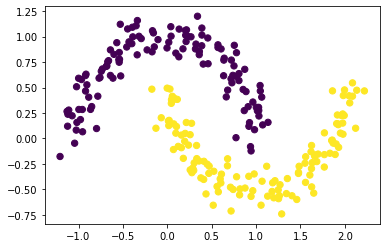

In [4]:
# Create a 2D numpy array from the x0 and x1 columns
X_orig = data[["x0", "x1"]].to_numpy()

# Create a 1D numpy array from the y column
y_orig = data["y"].to_numpy()

# Print the sizes of the generated 2D points X and the corresponding labels Y
print(f"Size X:{X_orig.shape}")
print(f"Size y:{y_orig.shape}")

# Visualize the dataset. The color of the points is determined by the labels `y_orig`.
plt.scatter(X_orig[:, 0], X_orig[:, 1], s=40, c=y_orig)
plt.show()

In [5]:
device = 'mps'

X = torch.tensor(X_orig, dtype=torch.float32).to(device)

y = torch.from_numpy(y_orig).type(torch.LongTensor).to(device)

print(f"Size x:{X.shape}")
print(f"Size y:{y.shape}")

Size x:torch.Size([256, 2])
Size y:torch.Size([256])


/var/folders/rh/7xnmdybn7778kzq927hfcn8c0000gn/T/ipykernel_4088/1705127477.py:3: UserWarning: The dst MTL buffer in copy_to_mps is non-contiguous (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/mps/operations/Copy.mm:358.)
  X = torch.tensor(X_orig, dtype=torch.float32).to(device)


## Section 3.2: Create a Simple Neural Network


* 1 input layer of size 2 (our points have 2 coordinates)

* 1 hidden layer of size 16 (you can play with different numbers here)

* 1 output layer of size 2 (we want the have the scores for the two classes)

### nn.Module 이해

* __init__ : 네트워크 구조 정의

* forward(매서드) : 네트워크가 필요한 연산을 정의한다고 하는데 정확히 감이 안옴

* predict(매서드) : 필수적으로 쓰는 항목은 아니긴한데 네트워크의 예측이 얼마나 정확한지 확인할 때 사용함. forward 매서드를 호출한다음 가장 점수가 높은 라벨을 택하는 방식이라함 

* train(매서드) : 필수적인 항목은 아님, 

In [7]:
class NaiveNet(nn.Module) :
    def __init__(self) -> None:
        super(NaiveNet,self).__init__()
    
        self.layers = nn.Sequential(
            nn.Linear(2,16),
            nn.ReLU(),
            nn.Linear(16,2),
        )

    def forward(self,x:torch.tensor) :
        # forward 매서드를 쓰면 input 값을 layer 계산에서 나온 결과값으로 반환
        return self.layers(x)

    def predict(self,x) :
        # 네트워크 결과 값에 대한 예측 수행

        # x값 forward에 넣기
        output = self.forward(x)

        # argmax는 index를 반환하는데 왜 사용하는지 잘 모르겠다. 일단 결과보고 재해석해보자
        return torch.argmax(output,1)

    def train(self,X,y) : 
        pass



In [8]:
model = NaiveNet().to(device)
print(model)

NaiveNet(
  (layers): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=2, bias=True)
  )
)


In [10]:
input = torch.tensor([[ 0.9066,  0.5052],
        [-0.2024,  1.1226],
        [ 1.0685,  0.2809],
        [ 0.6720,  0.5097],
        [ 0.8548,  0.5122]], device='mps')

out_f = model.forward(input)
out_p = model.predict(input)
print(out_f)
print(out_p)

/Users/yangwoolee/.pyenv/versions/3.9.1/lib/python3.9/site-packages/torch/_tensor_str.py:103: UserWarning: The operator 'aten::bitwise_and.Tensor_out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at  /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:11.)
  nonzero_finite_vals = torch.masked_select(tensor_view, torch.isfinite(tensor_view) & tensor_view.ne(0))


tensor([[-0.3853,  0.0570],
        [-0.5216, -0.0542],
        [-0.3308,  0.0812],
        [-0.3713,  0.0450],
        [-0.3839,  0.0539]], device='mps:0', grad_fn=<MpsLinearBackward0>)
tensor([1, 1, 1, 1, 1], device='mps:0')
